In [ ]:
#generate command strings that needs to be executed

#wayback_machine_downloader https://myanimelist.net/topanime.php?type=airing --exact-url --all-timestamps --from=20210104004616

data_path = "./data/myanimelist.net-top/"
#filename="topanime.php_type=airing"
filename="topanime.php"

In [ ]:
import os
import bs4
from tqdm import tqdm
import datetime
import re

def get_score_list(source):
    #regex search
    #method 1: scored ([0-9]\.[0-9][0-9]) then $1 for webpage in around 2008-2016
    #method 2: >([0-9]\.[0-9][0-9])< then $1 for webpage in ~2006, and 2017+
    #two methods are mutually exclusive, if one work, the other one won't work, that's great isn't it?
    #method 1
    x = re.findall("[Ss]cored ([0-9]\.[0-9][0-9])", source)
    if(len(x)>10):
        x = [float(item) for item in x]
        return x
    #method 2
    x = re.findall(">\s?([0-9]\.[0-9][0-9])\s?<",source)#\s match possible space
    if(len(x)>10):
        x = [float(item) for item in x]
        return x
    #by default return empty list
    return x

def get_rank_list(fn):
    #format:
    #1. <strong>...</strong> (.text)
    #2. h3, class=hoverinfo_trigger fl-l fs14 fw-b anime_ranking_h3
    #3. a,class=hoverinfo_trigger fs14 fw-b (.text)
    if(os.path.exists(fn)==False):
        fn+="_"
    with open(fn,"rb") as fp1:
        page_source=fp1.read()
        try:
            page_source = page_source.decode('ISO-8859-1')
        except Exception as e:
            #page_source = page_source.decode('ascii')
            print(fn)
            raise e
    soup = bs4.BeautifulSoup(page_source,'html.parser')
    ranklist=[]
    scorelist=get_score_list(page_source)
    #print(soup)
    #method 0
    ls = soup.findAll("a",attrs={"href":re.compile("^anime.php\?id=.*")})
    if(len(ls)>10):
        i=0
        for _,item in enumerate(ls):
            if(item.find("img") is None):
                title = item.text
                sc = scorelist[i]#possible index out of range, let's see]
                
                i+=1
                ranklist.append([sc,title])
        return ranklist
    #method 1
    ls = soup.findAll("strong")
    if(len(ls)>10):
        #print("strong work")
        #score: scored 8.91<br/>
        if(len(ls)>50):
            ls=ls[:50]#prevent capture extra stuff
        for i,item in enumerate(ls):
            title=item.text
            sc = scorelist[i]    
            ranklist.append([sc,title])
        return ranklist
    
    #method 2
    ls = soup.findAll("h3",attrs={"class":"hoverinfo_trigger fl-l fs14 fw-b anime_ranking_h3"})
    if(len(ls)>10):
        if(len(ls)>50):
            ls=ls[:50]#prevent capture extra stuff
        for i,item in enumerate(ls):
            title=item.find("a").text
            sc = scorelist[i]
            ranklist.append([sc,title])
        return ranklist
#     #method 3
#     ls = soup.findAll("a",attrs={"class":"hoverinfo_trigger fs14 fw-b"})
#     #print(ls)
#     if(len(ls)>10):
#         for item in ls:
#             title=item.text
#             #print(title)
#             ranklist.append(title)
#         return ranklist
    #method 4
    ls = soup.findAll("a",attrs={"class":"hoverinfo_trigger"})
    if(len(ls)>10):
        if(len(ls)>50):
            ls=ls[:50]#prevent capture extra stuff
        for i,item in enumerate(ls):
            if(item.find("img") is None):
                title=item.text
                try:
                    sc = scorelist[i]
                except Exception as e:
                    raise e
                ranklist.append([sc,title])
            
    return ranklist
                

In [ ]:
#process data file

errlist=[]
rank_time_list=[]
for foldername_ts in tqdm(os.listdir(data_path)):

    if(foldername_ts.startswith("20") == False):
        continue
    #print(foldername_ts)
    year=int(foldername_ts[:4])
    
    month=int(foldername_ts[4:6])
    day=int(foldername_ts[6:8])
    fn=os.path.join(data_path,foldername_ts,filename).replace("\\","/")
    
    #print(fn)
    s=""
    
    #print(s)
    rank_list = []
    if(os.path.exists(fn)):
        rank_list = get_rank_list(fn)
    
    
    if(len(rank_list)==0):
        errlist.append(fn)
    else:
        ts=(year,month,day)
        rank_time_list.append([ts,rank_list])
        
        #print(fn)
    #break
    
print("Errors:{}".format(len(errlist)))
print("Captured:{}".format(len(rank_time_list)))
    
    

In [ ]:
#for separation

In [ ]:
import json
datapath="./animerank-top.json"

with open(datapath,"w") as fp1:
    json.dump(rank_time_list,fp1)
print("saved to {}".format(datapath))

In [2]:
import json
datapath="./animerank-top.json"

with open(datapath,"r") as fp1:
    rank_time_list_raw=json.load(fp1)
print("loaded {} items".format(len(rank_time_list_raw)))
#print(errlist[-1])

loaded 2021 items


In [18]:
import numpy as np
#select one rec each month
rank_time_list_sel=[]
dates={}
minranklen=1000#minimum number of ranks
#dates[year][month]=?
for i in range(len(rank_time_list_raw)):
    row=rank_time_list_raw[i]
    date=row[0]
    ranks=row[1]
    minranklen=min(len(ranks),minranklen)
    year=date[0]
    month=date[1]
    if(year not in dates):
        dates[year]={}
    if(month not in dates[year]):
        dates[year][month]=1
        rank_time_list_sel.append(row)
#print(minranklen)
# for i in range(3):
#     print(rank_time_list_sel[i][1][0])
rank_time_list=[]
interpol_total_frames=100
interpol_num=30

#interpolation
#row[i] and row[i+1]:
#inbetween_score[i]=np.linspace(sc1,sc2,interpol_num)
#then append 100-interpol_num sc2 to stablize
prev_row=None
for i in range(len(rank_time_list_sel)):
    row=rank_time_list_sel[i]
    if(prev_row is None):
        prev_row=row
        rank_time_list.append(row)
        continue

        
    #create a (minranklen,interpol_total_frames) matrix and transpose
    ls_interpol=[None]*minranklen
    for j in range(minranklen):
        sc1=prev_row[1][j]
        sc2=row[1][j]
        
        
        sclist=list(np.linspace(sc1[0],sc2[0],interpol_num))
        for _ in range(interpol_total_frames-interpol_num):
            sclist.append(sc2[0])
        #if(j==3):
            #print(sc1,sc2)
            #print(sclist)
        ls_interpol[j]=sclist
    #print(ls_interpol)
    for k in range(interpol_total_frames):
        date=row[0]
        ranks=row[1]#ranks = [ [score,title] ]
        new_ranks=[]
        
        for j in range(minranklen):
            title=ranks[j][1]
            sc_new=ls_interpol[j][k]
            #if(j==3):
                #print("sc_new={},title={}".format(sc_new,title))

            new_ranks.append([sc_new,title])
        #print(date)
        rank_time_list.append([date,new_ranks])
        #print(rank_time_list[-1][1][3])
    prev_row=row
            
            
        
# for i in range(0,200,1):
#     print(rank_time_list[i][1][0])
print("selected {} items, interpolated to {} items".format(len(rank_time_list_sel),len(rank_time_list)))


selected 129 items, interpolated to 12801 items


In [19]:

import numpy as np
import datetime

#reuse code from safebooru

#get ranking number (y) for a specific date index
def ploty_one_date(dateidx):
    taglist = rank_time_list[dateidx][1]
    #[[1, 'uniform'], [1, 'toggles'], ...]
    y=np.array([tag[0] for tag in taglist])
    
    return y

#get ranking label (x labels) for a specific date index
def get_labels_one_date(dateidx=0):
    
    taglist = rank_time_list[dateidx][1]
    y=[tag[1] for tag in taglist]
    return y

def get_ts_str_one_date(dateidx=0):
    dt_tuple=rank_time_list[dateidx][0]
    s = datetime.datetime(dt_tuple[0],dt_tuple[1],dt_tuple[2]).strftime('%Y-%m-%d')
    return s
def get_ts_tuple_one_date(dateidx=0):
    dt_tuple=rank_time_list[dateidx][0]
    return dt_tuple


# ax.bar(x,y)
# plt.show()

<IPython.core.display.Javascript object>


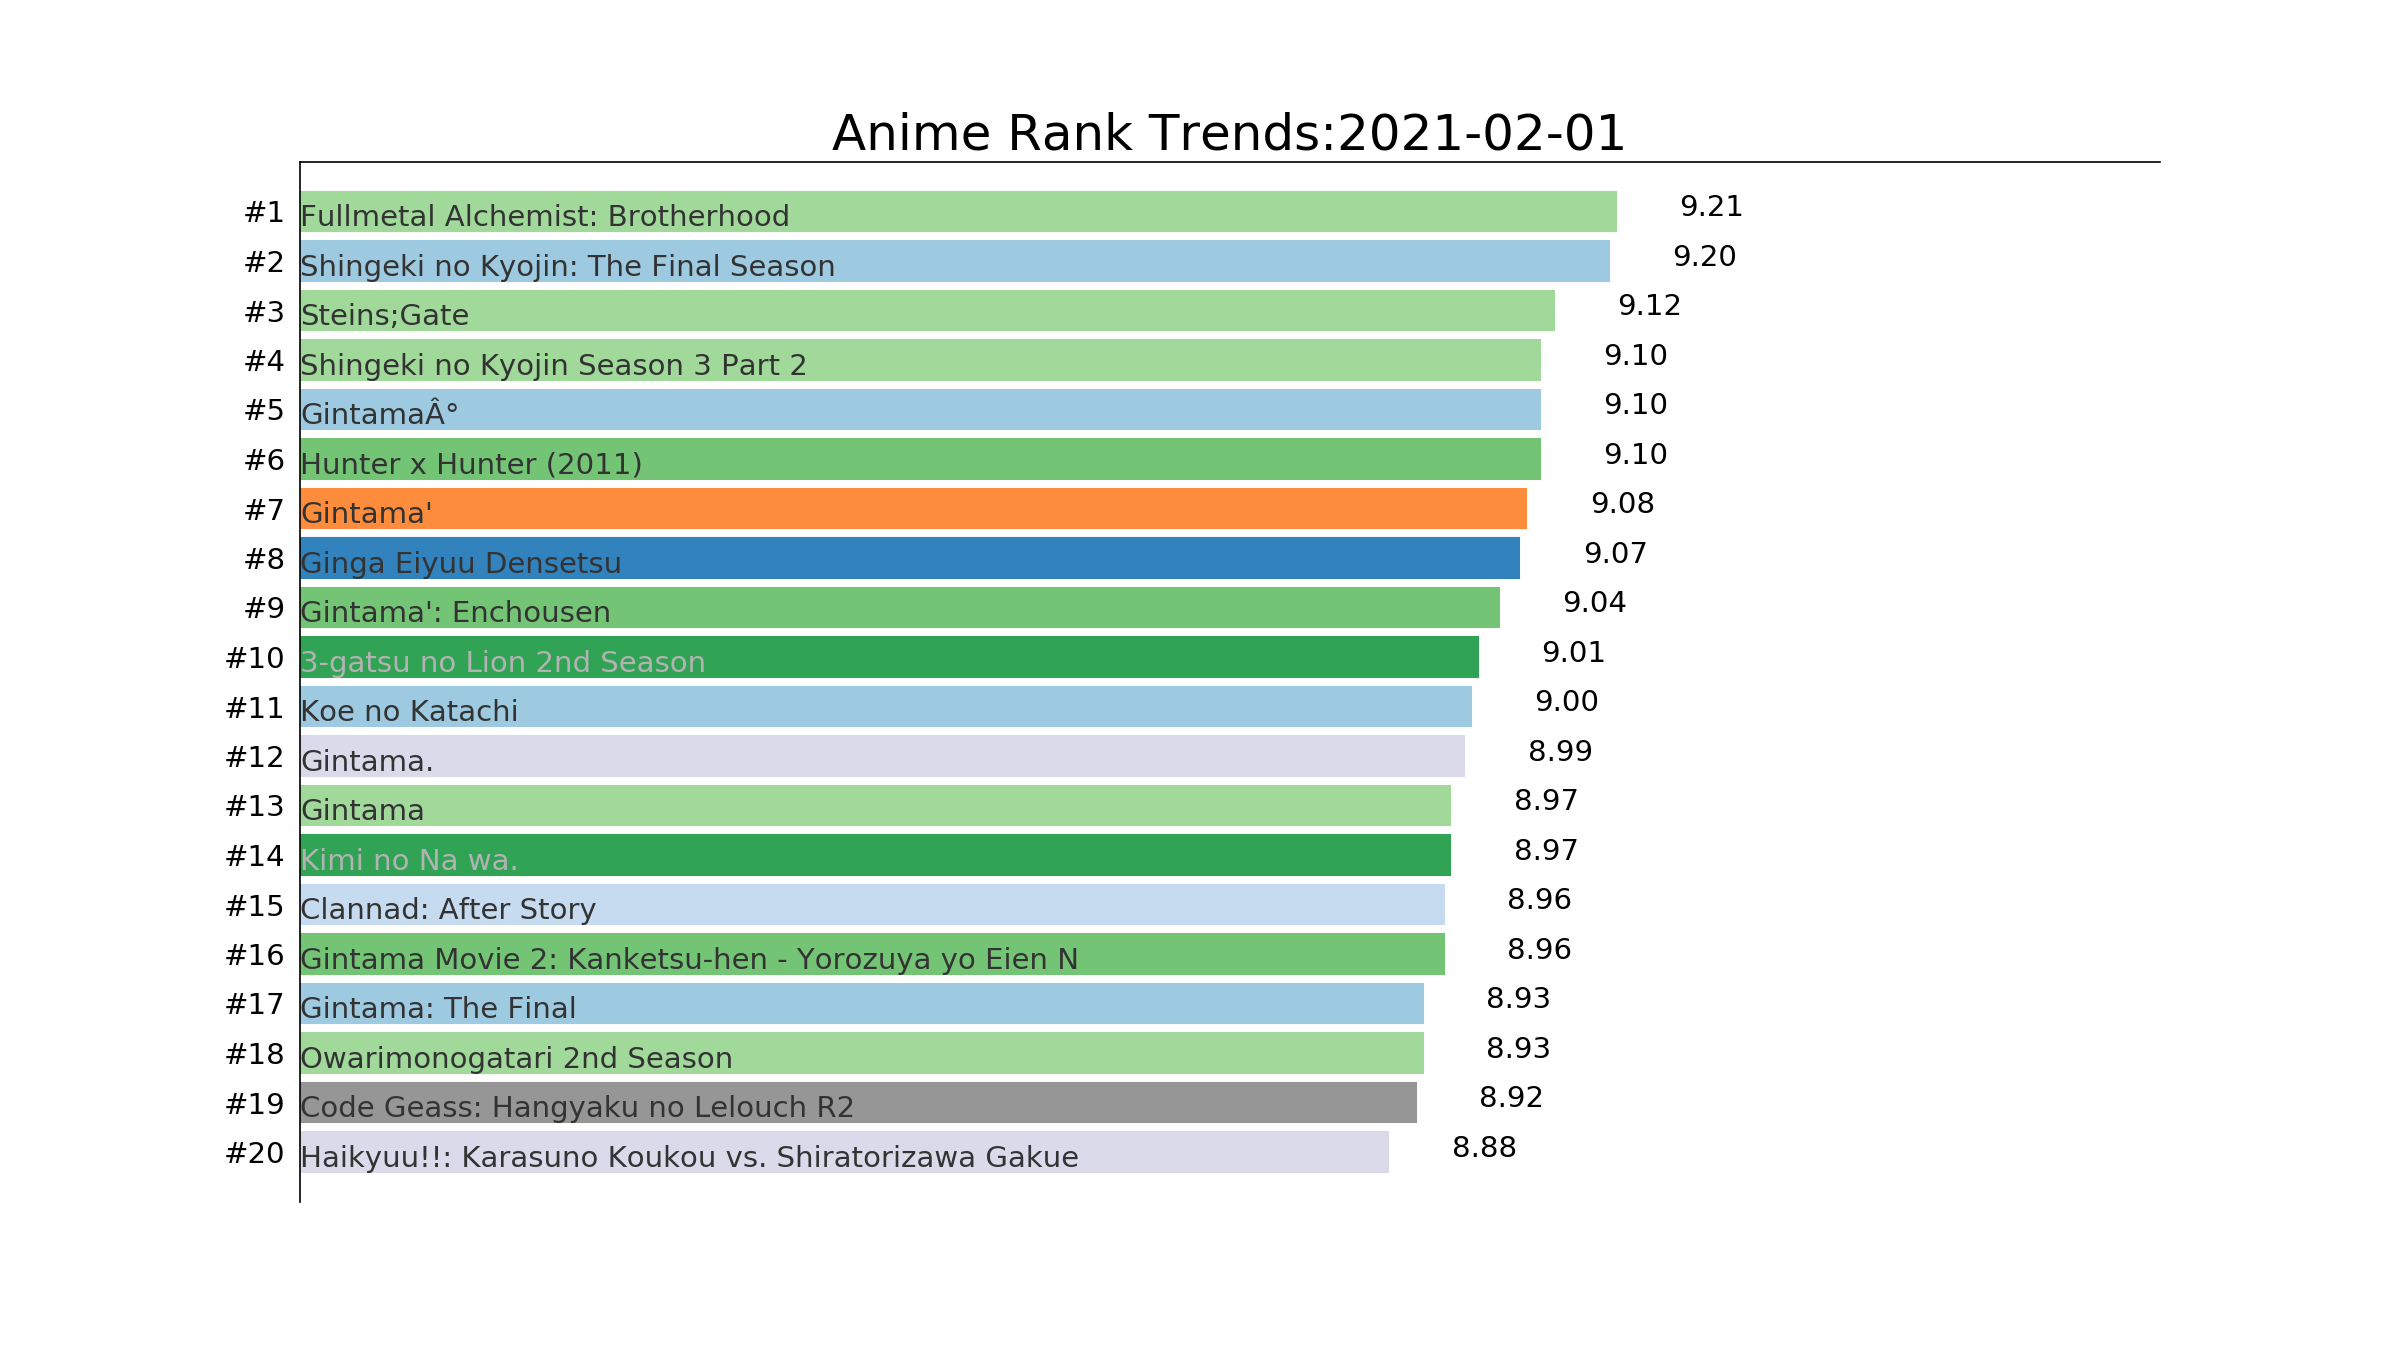

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']
done.


In [39]:
# horizontal bar version

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
%matplotlib notebook


random.seed(233)

day_init=0   #where do we start?
total_days=len(rank_time_list)#200 #how long do we count?
steps=1      #what strides when we go forward
X=20   #top labels
max_char_bar=50

fig, ax = plt.subplots(figsize=(16, 9))


#l = plt.plot(t, s)

#ax = plt.axis([0,X,-1,1])

x0=np.arange(1, X+1, 1)
xticklabels=["#{}".format(i) for i in range(X+1,0,-1)]
xticklabels[0]=""

y0=ploty_one_date(day_init)[::-1]#reverse!
y0=y0[:X]
ymin=min(y0)
ymax=max(y0)
xlim=(ymin-0.5,10)
ax.set_xlim(xlim)
ax.set_ylim(0,X+1)

# print(x0)
# print(y0)
bar_labels=[] #store data labels on top of each bar
bar_values=[] #store the height of each bar (independent from each tag)
colors = plt.get_cmap('tab20c', X+3)


barcollection = plt.barh(x0, y0)
plt.title("Anime Rank Trends",fontsize=12)
#date_anno = ax.text( (xlim[1]+xlim[0])*0.535,X*1.07, get_ts_str_one_date(day_init), ha='left', va='bottom', fontsize=12)


#hide ticks
ax.yaxis.set_major_locator(plt.MaxNLocator(22))
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=True)
#print(xticklabels)
ax.set_yticklabels(xticklabels,fontsize=14)


ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.spines['top'].set_visible(False)

tagcolor={}#store tag -> color

for i, b in enumerate(barcollection):
    width=b.get_width()
    labels=get_labels_one_date(day_init)[::-1]#reverse!
    tmp = ax.text(width+ymax*0.01, b.get_y()+0.3,  y0[i], fontsize=14)
    bar_labels.append(tmp)
    #tmp = ax.text(width-0.3, b.get_y()+0.1, "   {}".format(labels[i]), fontsize=8)
    tmp = ax.text(xlim[0], b.get_y()+0.1, "   {}".format(labels[i][:max_char_bar]), fontsize=14)
    bar_values.append(tmp)
    #rank count, fixed
    #tmp = ax.text(xlim[0]-0.1, b.get_y()+0.1, "   {}".format(X-i), fontsize=8)
    
    tagname=labels[i]
    if(tagname not in tagcolor):
        #choose a random one
        tagcolor[tagname]=colors(random.randint(0,X-1))
        pass
    b.set_color(tagcolor[tagname])
    #print(tagcolor[tagname])#format: rgba

#data=[k for k in range(X)]
#rounded rect

    

def animate(i_interpol):
    #global tagcolors
    #index need to be int, animate i maybe float
    idx=int(i_interpol)
    y = ploty_one_date(idx)[:X][::-1]#reverse!
    
    
    labels=get_labels_one_date(idx)[:X][::-1]#reverse!
    
    #set height
    ymax=max(y)
    #ymin=min(y)
    xlim=(ymin-0.5,10)
    for i, b in enumerate(barcollection):
        tagname=labels[i]
        if(tagname not in tagcolor):
            #choose a random one
            tagcolor[tagname]=colors(random.randint(0,X-1))
            pass
        
        width=y[i]
        b.set_width(width)
        #b.set_color(colors(X-i))
        b.set_color(tagcolor[tagname])
        
        #score
        txt=bar_labels[i]
        txt.set_x(width+ymax*0.01)
        txt.set_text("{:.2f}".format(y[i]))
        
        #anime name
        txt2=bar_values[i]
        #txt2.set_x(width-0.3)
        txt2.set_x(xlim[0])
        txt2.set_text(labels[i][:max_char_bar])
        colorsum=( sum(tagcolor[tagname][:3]) )/3
        if(colorsum<=0.4):
            txt2.set_color((0.7,0.7,0.7))
            
        else:
            txt2.set_color((0.2,0.2,0.2))
    
        
        ######
    #date_anno.set_x((xlim[1]+xlim[0])*0.515)
    #date_anno.set_text(get_ts_str_one_date(idx))
    plt.title("Anime Rank Trends:{}".format(get_ts_str_one_date(idx)),fontsize=24)
    
    ax.set_xlim(xlim)
    
        
    
    return

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=np.arange(day_init, total_days, steps), interval=1, repeat=False)
#plt.tight_layout()
plt.show()
# import matplotlib.animation as manimation
# print(manimation.writers.list())



# Writer = manimation.writers['ffmpeg']
# dpi=120
# writer = Writer(fps=60, metadata=dict(artist='Me'), bitrate=4000)
# myAnimation.save('im.mp4', writer=writer,dpi=dpi)
# print("done.")

In [24]:
# rk = get_rank_list("./data/myanimelist.net-top/20190312201647/topanime.php")
# for row in rk:
#     print(row)

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']


<IPython.core.display.Javascript object>


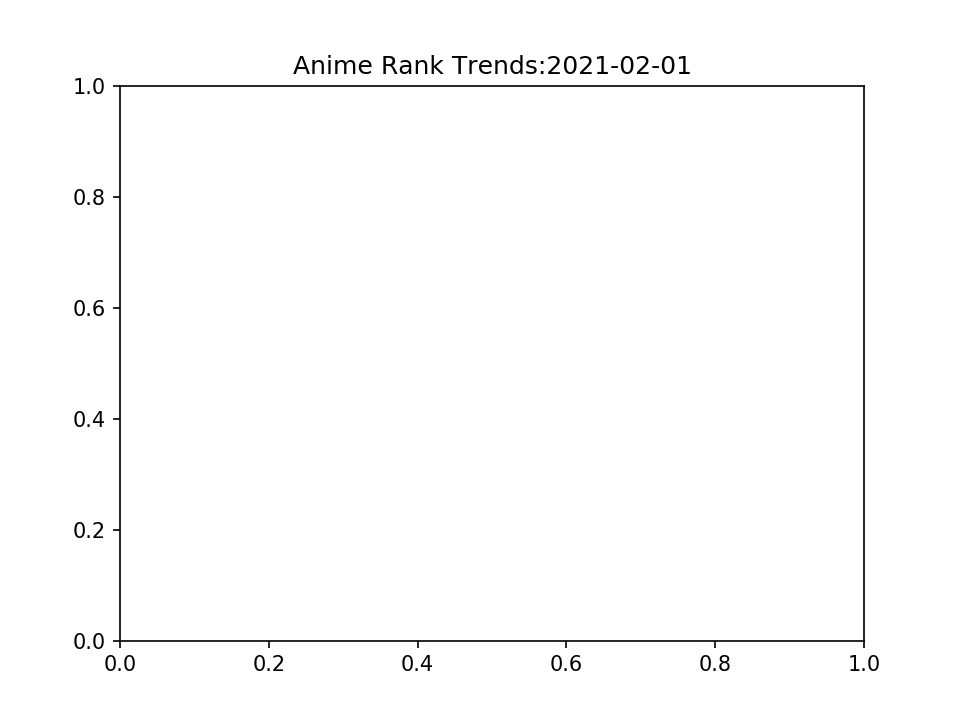

done.


In [30]:
import matplotlib.animation as manimation
print(manimation.writers.list())

# with open("anime-top-list-2006-2021.html","w") as fp1:
#     s = '<!DOCTYPE html> \
# <html> \
# <body>\n \
# {}\n\
# <p>Credit:<a href=https://www.kaggle.com/alamson/safebooru>Safebooru Kaggle Dataset</a></p>\
# </body> \
# </html>\n'.format(myAnimation.to_html5_video())
#     fp1.write(s)

Writer = manimation.writers['ffmpeg']
writer = Writer(fps=60, metadata=dict(artist='Me'), bitrate=4000)
myAnimation.save('im.mp4', writer=writer)
print("done.")